# Some algebra of generators, Brownian movements and showing some features of randomness


Python generators are some interesting beasts. They are vastly more powerful than functions and if you use the send method, they are full on coroutines. However in this post I want to examine a subset of its functionality first and determine the algebraic structures within that subset. 

I am going to examine generators with only using the yield keyword and yield keyword and use the generator expression syntax. Also internal state is allowed. 

E.g.

In [147]:
def fib():
    a = 0
    b = 1 
    while True:
        yield a
        t = (a + b)
        a = b 
        b = t

Because generators often won't stop producing data, they can be streams, infinite lists. We need some tools to properly observe them. For now observe, take and drop are enough.

In [148]:
def repeat(n):
    while True:
        yield n
        
def observe(n,gen):
    return list(next(gen) for _ in range (0,n))

def take(n, gen):
    yield from (next(gen) for _ in range(0,n))

def drop(n,gen):
    for _ in range(0,n):
        next(gen)
    yield from (next(gen) for _ in repeat(None))
        

In [149]:
list(take(10,fib()))

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

In [150]:
observe(10,take(10,fib())) == observe(10, fib())

True

In [151]:
observe(10,drop(10,fib()))

[55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181]

Now we have these, lets explore generators a bit more. I would like to show it are free monoids. 
A monoid is a algebraic structure with the following properties: 

It has a set *M*. An operation *(+)* that can add members of *M* together and will yield a new element of *M* and a special member *e* of *M* called unit. 

Further more the operation (+) is closed, that means that for every two members of *M* we get a new element of *M* and never go outside of *M*. 

Let's write down some rules for the monoid (a and b are members of M):

a + (b + c) = (a + b) + b (associativity)
a + e = e + a = a  (identity)

And certain monoids are commutative:

a + b = b + a (commutativity)

if a,b are members of M then so is a+b (closure)

Examples of monoids are the natural numbers, lists of elements and void in programming languages.

Then there is a special monoid, that can turn every set S of objects into a monoid. This is called the Free monoid. 

Lists are free monoids. We can lift all objects of set S in a list like so: 

M* = { List(x) for every x in S }

Now it is not a monoid yet, because we lack the structure. For example the above set M* misses the unit. So let's create that. First we tack on the empty list:

M = M* U { List() } 

List concatenation will be our operation. And with that we can create all strings of S. 
E.g let S = {a,b,c} then M will be {{a},{b},{c},{}} and we can combine these to form all strings like: 

aaa
abaca
babaaba

And whatever you can come up with.

It is not hard to show this indeed follow the rules, but I am not going to do that here. 

So that is nice, we can turn every set of objects into an monoid. That is why it is called free!

However to do something useful with this, we need to interpret this. That will come later.

## Generators can simulate lists

It is easy to show that every list can be a generator, but not every generator is a list, at least in python. If we allow infinite lists, the notions come closer together. 


In [152]:
def listToGenerator(lst):
    for i in lst:
        yield i 

observe(3,listToGenerator([1,2,3,4]))

[1, 2, 3]

And to show there are generators that are not lists (in python): 

In [153]:

def nonListGenerator():
    while True:
        yield 1

# list(nonListGenerator())

The above program will never finish. So better not run it. 

# Brownian motion

Brownian motion is the random movement we observe in a gas. It comes from the energy in each particle and its interactions with others. Wikipedia has a nice picture of this: 


![Brownian motion](https://upload.wikimedia.org/wikipedia/commons/5/51/Brownianmotion5particles150frame.gif)

We can simulate a discrete version of this by taking a random source, transforming it outputs into directions and applying these to a particle.

Let's call this the random taxicab ride, to honor the [taxicab metric](https://en.wikipedia.org/wiki/Taxicab_geometry). And we are going to define it with generators as free monoids and some utilities we will write to visualize our taxi. 

The goal is to get a stream of positions of our cab. Lets build this.
First we import some utilities:

In [154]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import default_rng


Then we need to think about the movements of our cab. How many degrees of freedom does it have? I count 4. It can go left, right, up and down. So we want a stream that generate a random stream of {1,2,3,4}'s

In [155]:
# Some seed to keep things deterministically
seed = 123567

def defaultCabDirections(seed):
    rng = default_rng(seed = seed)
    while True:
        yield rng.integers(1,5)

In [156]:
observe(10,defaultCabDirections(seed))

[3, 1, 4, 4, 4, 2, 3, 3, 2, 1]

Nice that works!
Now we need to model our taxi. We can imagine it runs on an infinite grid of integer positions and the taxi itself has a position. So a reasonable model of our taxi would be this:

$$ taxi = \pmatrix{x \\ y} $$

Just its position. For the movement we need to map every direction into a vector: 

$$L = \pmatrix{-1 \\ 0}$$
$$R = \pmatrix{1 \\ 0}$$
$$U = \pmatrix{0 \\ 1}$$
$$D = \pmatrix{0 \\ -1}$$

And we can define a distance as follow:
$$d(a,b) = |a_1 - b_1| + |a_2 - b_2|$$

That is the distance the taxi should travel to go from point a to b. 

We can easily show that the taxi can travel everywhere combining the above vectors, given a random position (x,y):

$$\pmatrix{x\\y} = x \pmatrix{1 \\ 0} + y  \pmatrix{0 \\ 1}$$

So our final model of the taxi is a starting position and a stream of directions:

$$taxi = \{\pmatrix{x \\ y}, \{L,R,U,...\}\}$$


And with observe and drop, we can observe the taxi in any point of time.

In [157]:
def distance(a,b):
    return np.sum(np.absolute(a - b))


def gmap(f,gen):
    yield from (f(x) for x in gen)
    
# map directions to a vector
def dirToVec(x):
    if x == 1: # L 
        return np.array([-1,0])
    if x == 2: # R
        return np.array([1,0])
    if x == 3: # U
        return np.array([0,1])
    if x == 4: # D
        return np.array([0,-1])
    
def taxiMovements(cabDirections,seed):
    yield from gmap(dirToVec,cabDirections(seed)) 
    
    
(observe(5, taxiMovements(defaultCabDirections,seed)),
distance(np.array([2,0]),np.array([0,-1])))


([array([0, 1]),
  array([-1,  0]),
  array([ 0, -1]),
  array([ 0, -1]),
  array([ 0, -1])],
 3)

Nice, we build some up some nice vocabulary and en passant show that generators are (endo) functors by writing a map function for it. 

Now we need a generator that takes in the above generator and maps it into a stream  of positions of the taxi. This generator takes in a start position and then generates the positions. This will be the interpreter of our taxi monoid. 

And to be honest it is a bit more than a monoid. It is a group, because $$L,R$$ and $$U,D$$ are inverses of each other. 

This can be easily seen by: 

$$ L = \pmatrix{-1 \\ 0} $$ 
$$ R = \pmatrix{1 \\ 0} $$ 
$$ L + R = \pmatrix{0 \\ 0}$$

Vice versa for up and down. So the directions form a group! And further more $$\{L,R,U,D\}$$ are the generators of the group. We can define every other member of the group with them. We can build the taxi now:


In [158]:
def fold(f,s,g):
    for x in g:
        s = f(s,x)
        yield s
        
def taxi(pos = np.array([0,0]),seed = seed, cabDirections = defaultCabDirections):
    yield from fold(lambda current_pos,direction: np.add(current_pos,direction),pos,taxiMovements(cabDirections, seed))

In [159]:
observe(10,taxi())

[array([0, 1]),
 array([-1,  1]),
 array([-1,  0]),
 array([-1, -1]),
 array([-1, -2]),
 array([ 0, -2]),
 array([ 0, -1]),
 array([0, 0]),
 array([1, 0]),
 array([0, 0])]

Nice, now we can plot how our taxi moves, play around with steps if you like:

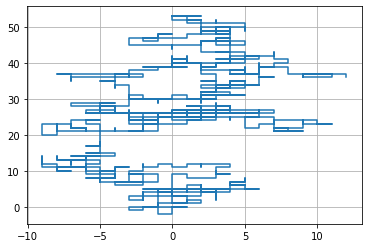

In [160]:

steps = 500


def observeArray(n,g):
     return np.asarray(observe(n, g))

import matplotlib.pyplot as plt
def showTaxiPath(steps, taxi): 
    fig = plt.figure()
    ax = plt.axes()
    plt.grid()
    x,y = observeArray(steps,taxi).T
    plt.plot(x,y)
    
showTaxiPath(1000, taxi())

Or a bit more fancy, we can see what places our random taxi visits the most: 

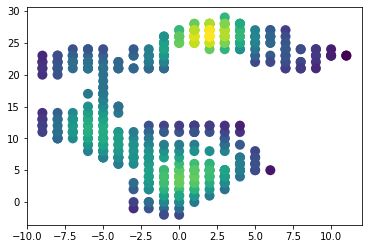

In [169]:
from scipy.stats import gaussian_kde
def densityScatterPlot(x,y): 
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100, edgecolor='')
densityScatterPlot(x,y)

def normalScatterPlot(x,y):
    fig, ax = plt.subplots()
    ax.scatter(x,y)


We have all the neccessary tools to do some cool stuff now. 

# Compression and randomness
What is compression? Well compression means we take some information and remove all redundandant information. How do we compress? By studying the structure of the information we have. And fortunately we have a group structure! And a stream of elements of a group structure, that is something we can compress very, very well, even though it is mostly random:

$$(\textbf{start_position},\{L,R,U,L,R,D,U\}) \rightarrow (\textbf{start_position},\{U\})$$

Let's write this compression function over an interval:


In [162]:
def compress(interval, gen):
    while True:
        chunk = take(interval, gen)
        gen = drop(interval, gen)
        yield np.trunc(sum(chunk)/interval)

observe(10, compress(10,taxi()))

[array([-0., -0.]),
 array([0., 1.]),
 array([0., 4.]),
 array([-0.,  4.]),
 array([3., 4.]),
 array([3., 5.]),
 array([2., 8.]),
 array([-0., 11.]),
 array([-2.,  6.]),
 array([-5.,  8.])]


Now something funny will happen, because we are using a presumably good random source, the picture should condensate to a center.


In [167]:
import sys
# We are playing with generators, so we want this to be a bit higher. 
sys.setrecursionlimit(100000)
def compressCab(compressionRatio, plot = densityScatterPlot, steps = steps, pos = np.array([0,0]),seed = seed, cabDirections = defaultCabDirections):
    compressedTaxicab = compress(compressionRatio, taxi(pos,seed,cabDirections))
    cx,cy = observeArray(steps, compressedTaxicab).T
    plot(cx,cy)


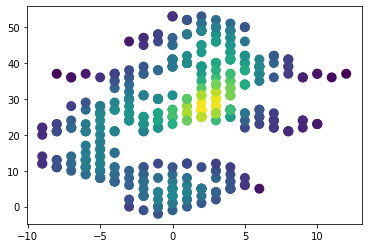

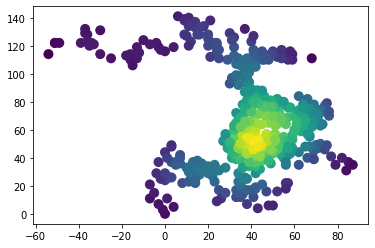

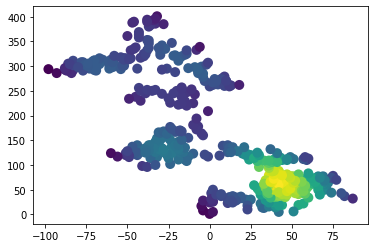

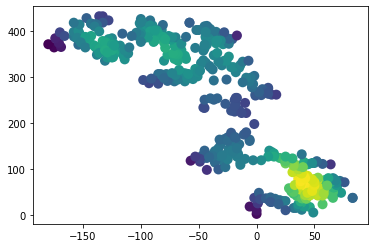

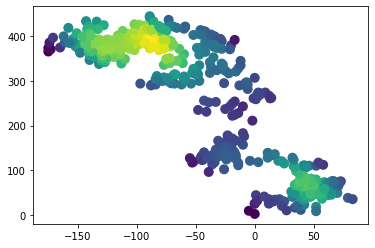

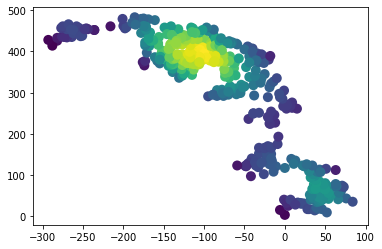

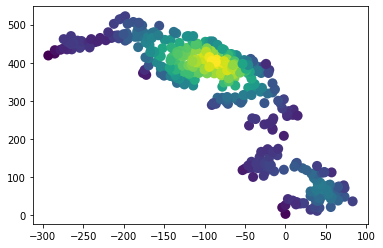

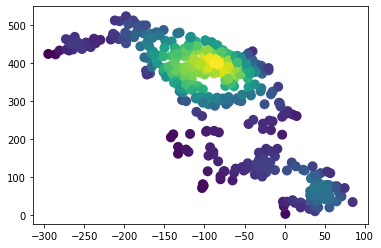

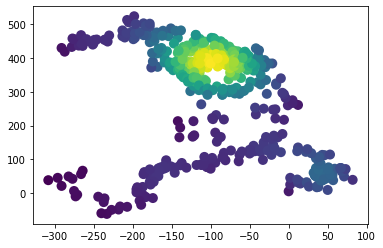

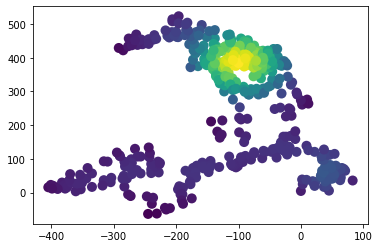

In [173]:
for ratio in range(1, 200, 20):
    compressCab(ratio, plot = densityScatterPlot)
    

# Crappy random generators


Now we can finally have some fun! We have build the tools to make a crappy random generator detector.
Let's build some bad random number generators first. 

On a first sight, this looks like an easy task. But it is very hard to find well documented really bad random generators.

In [165]:
def someShitRandomGenerator(seed):
    while True:
        yield 3
        yield 4
        yield 2
        yield 4

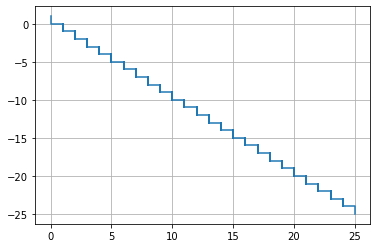

In [171]:
crappyTaxi = taxi(cabDirections = someShitRandomGenerator)
showTaxiPath(100, crappyTaxi)

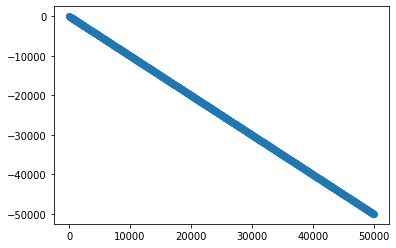

In [172]:
compressCab(100,plot=normalScatterPlot, steps=1000,cabDirections = someShitRandomGenerator)